<h1 style="text-align: center;">Module 1. Structured data processing using neural networks
</h1>
<h2 style="text-align: center;">Topic 2. Logistic regression. Artificial neuron</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import warnings
# filter warnings
warnings.filterwarnings('ignore')

## Dataset owerview

[Spaceship Titanic dataset](https://www.kaggle.com/competitions/spaceship-titanic/overview)

**Data Field Description:**
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age` - The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Exploratory Data Analysis

In [2]:
# Reading data

df = pd.read_csv('../data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

In [3]:
# Dataset preview

df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Number of records and columns

df.shape

(8693, 13)

In [5]:
# Basic dataset info 

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [6]:
TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

In [7]:
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

In [8]:
print(f'Number of categorical features: {len(cat_features)}')
print('Categorical features:', cat_features, '\n')
print(f'Number of continuos features: {len(cont_features)}')
print('Continuos features:', cont_features, '\n')
print(f'Number of text features: {len(text_features)}')
print('Text features:', text_features)

Number of categorical features: 4
Categorical features: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'] 

Number of continuos features: 6
Continuos features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] 

Number of text features: 2
Text features: ['Cabin', 'Name']


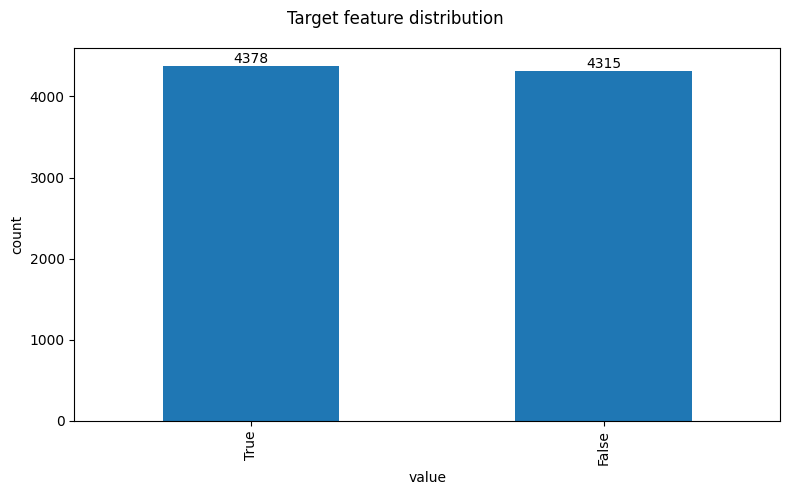

In [9]:
ax = df[TARGET].value_counts().plot(kind='bar', figsize=(8, 5))
for i in ax.containers:
    ax.bar_label(i)
    ax.set_xlabel("value")
    ax.set_ylabel("count")
            
plt.suptitle("Target feature distribution")

plt.tight_layout()
plt.show()

We can see that the target feature is distributed equally. That means we can use accuracy as a metric.

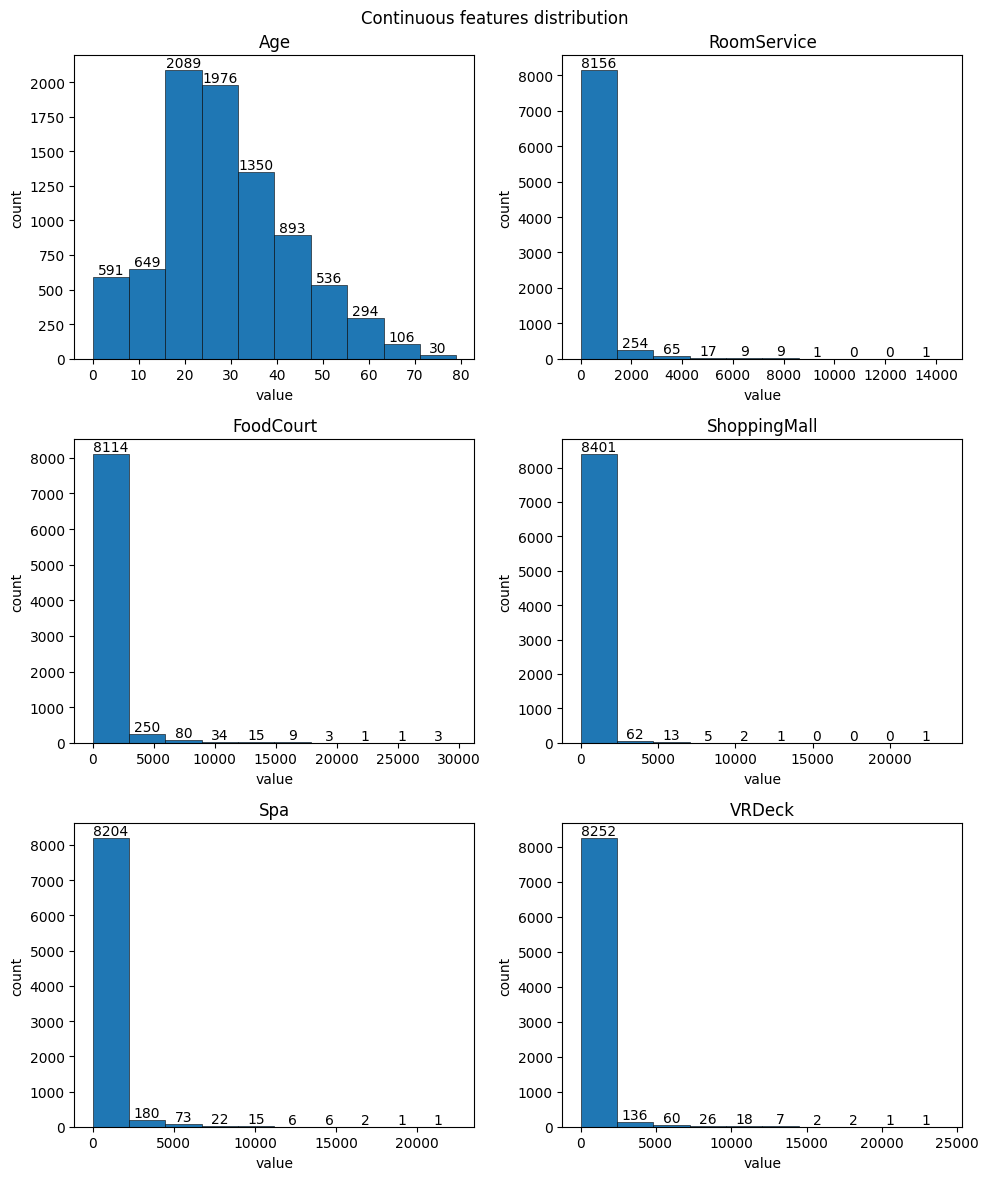

In [10]:
# Continuous features

ax = df.loc[:, cont_features].hist(figsize=(10, 12), grid=False, edgecolor='black', linewidth=.4)
for row in ax:
    for col in row:
        for i in col.containers:
            col.bar_label(i)
            col.set_xlabel("value")
            col.set_ylabel("count")
        
plt.suptitle("Continuous features distribution")

plt.tight_layout()
plt.show()

It looks like most of the passengers didn't use luxury services - all luxury amenities plots are heavily left-skewed. Let's create binary features for this services: if passanger used the service or not.

In [11]:
services_features = cont_features[1:]

In [12]:
for feature in services_features:
    df[f'used_{feature}'] = df.loc[:, feature].apply(lambda x: 1 if x > 0 else 0)

In [13]:
# Correlation matrix

df.loc[:, cont_features + ['CryoSleep', 'VIP', TARGET]].corr().style.background_gradient()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,VIP,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.074273,0.092819,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.252396,0.058785,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,-0.211510,0.129799,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,-0.212514,0.018295,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.203991,0.061059,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.198857,0.125974,-0.207075
CryoSleep,-0.074273,-0.252396,-0.211510,-0.212514,-0.203991,-0.198857,1.000000,-0.081402,0.468645
VIP,0.092819,0.058785,0.129799,0.018295,0.061059,0.125974,-0.081402,1.000000,-0.037650
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,0.468645,-0.037650,1.000000


We can see that input features are not correlated with oneself. So we won't drop any of the features.

## Preprocessing

In [14]:
# Imputing Missing Values 

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

In [15]:
df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

In [16]:
df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

In [17]:
display(df['CryoSleep'].value_counts())
display(df['VIP'].value_counts())

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

VIP
False    8291
True      199
Name: count, dtype: int64

In [18]:
df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

In [19]:
dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

In [20]:
dummies

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Gallifrey,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_Skaro,Destination_TRAPPIST-1e
PassengerId,,,,,,,,
0001_01,0,1,0,0,0,0,0,1
0002_01,1,0,0,0,0,0,0,1
0003_01,0,1,0,0,0,0,0,1
0003_02,0,1,0,0,0,0,0,1
0004_01,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
9276_01,0,1,0,0,1,0,0,0
9278_01,1,0,0,0,0,1,0,0
9279_01,1,0,0,0,0,0,0,1


In [21]:
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

In [22]:
df[TARGET] = df[TARGET].astype(int)

In [23]:
# For now, dropping textual features

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [24]:
# Train/test split

X = df.drop(TARGET , axis =1 )
y = df[TARGET]

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)
# use stratify=y to ensure that the distribution of the target variable will be preserved in train/test datasets

In [26]:
# For further computation purpuses, let's transpose input data

x_train = X_train.T
x_test = X_test.T
y_train = np.expand_dims(y_train.T, 0)
y_test = np.expand_dims(y_test.T, 0)

print('X train size', x_train.shape)
print('X test size', x_test.shape)
print('y train size', y_train.shape)
print('y test size', y_test.shape)

X train size (23, 5824)
X test size (23, 2869)
y train size (1, 5824)
y test size (1, 2869)


## Initializing parameters

In [27]:
# A function to initialize parameters

def initialize_weights_and_bias(dimension):
    # dimension - number of input features
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

## Forward Propagation

In [28]:
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

In [29]:
def forward_propagation(w,b,x_train,y_train):
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z) # probabilistic 0-1
    loss = -1*y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    return cost 

## Gradient Descent

In [30]:
# In backward propagation we will use y_head that found in forward progation
# Therefore instead of writing backward propagation method, lets combine forward propagation and backward propagation

def forward_backward_propagation(w,b,x_train,y_train, eps=1e-5):
    
    # forward propagation
    
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -1*y_train*np.log(y_head+eps)-(1-y_train)*np.log(1-y_head+eps)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    
    # backward propagation
    
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    
    return cost,gradients

In [31]:
# Updating(learning) parameters

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    index = []
    
    # updating(learning) parameters is number_of_iterarion times
    
    for i in range(number_of_iterarion):
        
        # make forward and backward propagation and find cost and gradients
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        # lets update
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        index.append(i)
        
    # we update(learn) parameters weights and bias
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    return parameters, gradients, cost_list

In [32]:
def predict(w,b,x_test):
    
    # x_test is a input for forward propagation
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0)
    
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Lets put them all together

In [33]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    
    # initialize
    
    dimension =  x_train.shape[0]  # that is 4096
    w,b = initialize_weights_and_bias(dimension)
    
    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

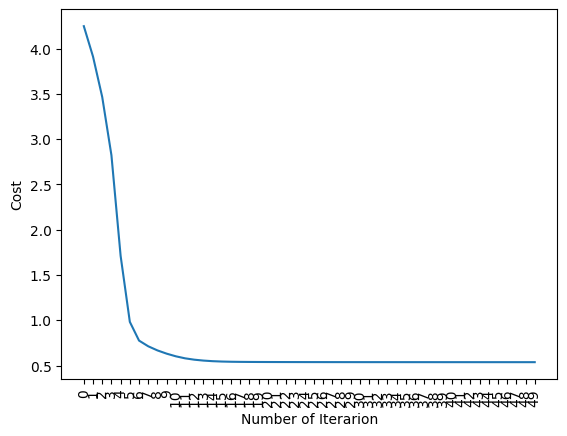

train accuracy: 77.93612637362638 %
test accuracy: 79.36563262460788 %


In [34]:
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.00001, num_iterations = 50) 